In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0423

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 568ms/step - loss: 0.0290
Average validation loss: 0.7330721020698547
4/4 [==============================] - 5s 579ms/step - loss: 0.0290 - val_loss: 0.7331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 553ms/step - loss: 0.0185 - val_loss: 0.7331
Average validation loss: 0.6682058572769165
4/4 [==============================] - 7s 569ms/step - loss: 0.0185 - val_loss: 0.7006
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 9s 567ms/step - loss: 0.0131 - val_loss: 0.7006
Average validation loss: 0.6321566700935364
4/4 [==============================] - 9s 583ms/step - loss: 0.0131 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 678ms/step - loss: 4.4995e-07
Average validation loss: 0.0015140646137297153
8/8 [==============================] - 6s 690ms/step - loss: 4.4995e-07 - val_loss: 0.0015
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 686ms/step - loss: 4.7111e-07 - val_loss: 0.0015
Average validation loss: 0.0004656858800444752
8/8 [==============================] - 11s 699ms/step - loss: 4.7111e-07 - val_loss: 9.8988e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 697ms/step - loss: 4.4898e-07 - val_loss: 9.8988e-04
Average validation loss: 0.0005810699367430061
8/8 [==============================] - 1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 681ms/step - loss: 2.4735e-06
Average validation loss: 0.04282345580698651
12/12 [==============================] - 8s 692ms/step - loss: 2.4735e-06 - val_loss: 0.0428
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 712ms/step - loss: 2.5465e-06 - val_loss: 0.0428
Average validation loss: 0.04751920563747566
12/12 [==============================] - 17s 723ms/step - loss: 2.5465e-06 - val_loss: 0.0452
Epoch 3/10
12/12 [==============================] - 25s 680ms/step - loss: 2.4604e-06 - val_loss: 0.0452
Average validation loss: 0.019037923115926485
12/12 [==============================] - 25s 690ms/step - loss: 2.4604e-06 - val_loss: 0.0365
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weight

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 697ms/step - loss: 1.1361e-06
Average validation loss: 0.06060150160919875
16/16 [==============================] - 11s 707ms/step - loss: 1.1361e-06 - val_loss: 0.0606
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 725ms/step - loss: 1.1725e-06 - val_loss: 0.0606
Average validation loss: 0.11121262796223164
16/16 [==============================] - 23s 736ms/step - loss: 1.1725e-06 - val_loss: 0.0859
Epoch 3/10
16/16 [==============================] - 34s 683ms/step - loss: 1.2150e-06 - val_loss: 0.0859
Average validation loss: 0.11656164583837823
16/16 [==============================] - 34s 694ms/step - loss: 1.2150e-06 - val_loss: 0.0961
Epoch 4/10
16/16 [==============================] - 45s 703ms/step - loss: 1.2282e-06 - val_loss: 0.0961
Average validation

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 700ms/step - loss: 5.0668e-07
Average validation loss: 0.03594853729009628
20/20 [==============================] - 14s 710ms/step - loss: 5.0668e-07 - val_loss: 0.0359
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 696ms/step - loss: 4.5153e-07 - val_loss: 0.0359
Average validation loss: 0.030858902772888542
20/20 [==============================] - 28s 706ms/step - loss: 4.5153e-07 - val_loss: 0.0334
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 42s 683ms/step - loss: 4.2442e-07 - val_loss: 0.0334
Average validation loss: 0.02517254357226193
20/20 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 696ms/step - loss: 7.8580e-07
Average validation loss: 0.07023642212152481
24/24 [==============================] - 17s 705ms/step - loss: 7.8580e-07 - val_loss: 0.0702
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 690ms/step - loss: 9.2736e-07 - val_loss: 0.0702
Average validation loss: 0.021622284315526485
24/24 [==============================] - 34s 700ms/step - loss: 9.2736e-07 - val_loss: 0.0459
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 50s 684ms/step - loss: 9.3171e-07 - val_loss: 0.0459
Average validation loss: 0.04014676436781883
24/24 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 685ms/step - loss: 2.9177e-06
Average validation loss: 0.10321519561111928
40/40 [==============================] - 28s 695ms/step - loss: 2.9177e-06 - val_loss: 0.1032
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 691ms/step - loss: 2.7010e-06 - val_loss: 0.1032
Average validation loss: 0.038486247137188914
40/40 [==============================] - 56s 700ms/step - loss: 2.7010e-06 - val_loss: 0.0709
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 83s 677ms/step - loss: 2.7047e-06 - val_loss: 0.0709
Average validation loss: 0.0351570937782526
40/40 [==============================] - 8

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 694ms/step - loss: 1.2071e-06
Average validation loss: 0.020062871898214023
48/48 [==============================] - 34s 704ms/step - loss: 1.2071e-06 - val_loss: 0.0201
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 700ms/step - loss: 9.3271e-07 - val_loss: 0.0201
Average validation loss: 0.016780482954345644
48/48 [==============================] - 68s 711ms/step - loss: 9.3271e-07 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 102s 701ms/step - loss: 7.4559e-07 - val_loss: 0.0184
Average validation loss: 0.019248260495563347
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 677ms/step - loss: 1.6578e-06
Average validation loss: 0.032194471186293025
56/56 [==============================] - 38s 686ms/step - loss: 1.6578e-06 - val_loss: 0.0322
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 76s 675ms/step - loss: 1.2700e-06 - val_loss: 0.0322
Average validation loss: 0.023862719419412315
56/56 [==============================] - 77s 684ms/step - loss: 1.2700e-06 - val_loss: 0.0280
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 116s 696ms/step - loss: 1.3826e-06 - val_loss: 0.0280
Average validation loss: 0.028519375873396972
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 700ms/step - loss: 9.4110e-07
Average validation loss: 0.01835152253624983
64/64 [==============================] - 46s 711ms/step - loss: 9.4110e-07 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 691ms/step - loss: 5.8073e-07 - val_loss: 0.0184
Average validation loss: 0.01957144757034257
64/64 [==============================] - 90s 701ms/step - loss: 5.8073e-07 - val_loss: 0.0190
Epoch 3/10
64/64 [==============================] - 135s 696ms/step - loss: 4.3715e-07 - val_loss: 0.0190
Average validation loss: 0.03764320025220513
64/64 [==============================] - 136s 706ms/step - loss: 4.3715e-07 - val_loss: 0.0252
Epoch 4/10
64/64 [==============================] - 180s 694ms/step - loss: 3.5511e-07 - val_loss: 0.0252
Average validat

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 700ms/step - loss: 1.2517e-06
Average validation loss: 0.026995643352468807
72/72 [==============================] - 51s 710ms/step - loss: 1.2517e-06 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 692ms/step - loss: 7.7474e-07 - val_loss: 0.0270
Average validation loss: 0.020241712944375143
72/72 [==============================] - 102s 702ms/step - loss: 7.7474e-07 - val_loss: 0.0236
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 152s 692ms/step - loss: 5.7061e-07 - val_loss: 0.0236
Average validation loss: 0.017159165866259072
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 61s 760ms/step - loss: 5.7400e-07
Average validation loss: 0.026619191654026507
80/80 [==============================] - 62s 771ms/step - loss: 5.7400e-07 - val_loss: 0.0266
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 122s 753ms/step - loss: 4.4699e-07 - val_loss: 0.0266
Average validation loss: 0.024836764810606836
80/80 [==============================] - 123s 763ms/step - loss: 4.4699e-07 - val_loss: 0.0257
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 178s 689ms/step - loss: 3.4747e-07 - val_loss: 0.0257
Average validation loss: 0.014186921948567032
80/80 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 705ms/step - loss: 1.5933e-06
Average validation loss: 0.07431775874768694
96/96 [==============================] - 69s 715ms/step - loss: 1.5933e-06 - val_loss: 0.0743
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 702ms/step - loss: 1.0364e-06 - val_loss: 0.0743
Average validation loss: 0.028255848272237927
96/96 [==============================] - 137s 712ms/step - loss: 1.0364e-06 - val_loss: 0.0513
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 704ms/step - loss: 8.0143e-07 - val_loss: 0.0513
Average validation loss: 4.140424927075704
96/96 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 700ms/step - loss: 7.2915e-07
Average validation loss: 0.04895878334840139
120/120 [==============================] - 85s 710ms/step - loss: 7.2915e-07 - val_loss: 0.0490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 704ms/step - loss: 4.7853e-07 - val_loss: 0.0490
Average validation loss: 0.017863629882534347
120/120 [==============================] - 171s 714ms/step - loss: 4.7853e-07 - val_loss: 0.0334
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 256s 708ms/step - loss: 3.5776e-07 - val_loss: 0.0334
Average validation loss: 0.06481498690942923
120/120 [=================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 698ms/step - loss: 3.7207e-07
Average validation loss: 0.016097226293721987
144/144 [==============================] - 102s 708ms/step - loss: 3.7207e-07 - val_loss: 0.0161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 203s 705ms/step - loss: 3.5779e-07 - val_loss: 0.0161
Average validation loss: 0.015533382477668865
144/144 [==============================] - 205s 715ms/step - loss: 3.5779e-07 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 306s 699ms/step - loss: 2.8591e-07 - val_loss: 0.0158
Average validation loss: 0.015245502248742722
144/144 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 702ms/step - loss: 1.5495e-07
Average validation loss: 0.015190148626197697
160/160 [==============================] - 114s 711ms/step - loss: 1.5495e-07 - val_loss: 0.0152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 226s 703ms/step - loss: 1.1075e-07 - val_loss: 0.0152
Average validation loss: 0.011637124549270083
160/160 [==============================] - 228s 714ms/step - loss: 1.1075e-07 - val_loss: 0.0134
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 339s 694ms/step - loss: 9.0213e-08 - val_loss: 0.0134
Average validation loss: 0.011660099772416287
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 719ms/step - loss: 1.5559e-06
Average validation loss: 0.050808476842939855
200/200 [==============================] - 146s 729ms/step - loss: 1.5559e-06 - val_loss: 0.0508
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 715ms/step - loss: 1.0065e-06 - val_loss: 0.0508
Average validation loss: 0.07987286951392888
200/200 [==============================] - 291s 725ms/step - loss: 1.0065e-06 - val_loss: 0.0653
Epoch 3/10
200/200 [==============================] - 434s 716ms/step - loss: 7.3503e-07 - val_loss: 0.0653
Average validation loss: 0.04735842920839786
200/200 [==============================] - 436s 726ms/step - loss: 7.3503e-07 - val_loss: 0.0593
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:43 - loss: 3.9110e-08

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 700ms/step - loss: 6.5298e-07
Average validation loss: 0.021644443488912656
240/240 [==============================] - 170s 710ms/step - loss: 6.5298e-07 - val_loss: 0.0216
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 339s 703ms/step - loss: 4.1620e-07 - val_loss: 0.0216
Average validation loss: 0.017091902895481327
240/240 [==============================] - 342s 713ms/step - loss: 4.1620e-07 - val_loss: 0.0194
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 510s 703ms/step - loss: 3.1205e-07 - val_loss: 0.0194
Average validation loss: 0.014950590926552347
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1302861103496535, 0.0332768685487008, 0.0788440247968786, 0.056341056890986556, 0.03031449539898313, 0.02613175935320517, 0.03475333085862075, 0.03122048322962655, 0.045035129348024, 0.0596334847498656, 0.030640570248961007, 0.025421343543479455, 0.13982294222466105, 0.03350289784177876, 0.03214366345794499, 0.023706257337877106, 0.041164898930721394, 0.014163401844147301]
std_val_losses =  [0.2128124031456147, 0.029554660662027665, 0.05899950988343924, 0.032435827631619576, 0.011322233570909215, 0.015125552298922797, 0.03546510927679364, 0.05666188747156905, 0.07206181213441601, 0.09678255632810734, 0.03301020850166244, 0.02346583433279026, 0.5789065658594178, 0.03279900861910145, 0.08013231256605147, 0.03337653801805338, 0.04020100777784831, 0.004335358299309608]


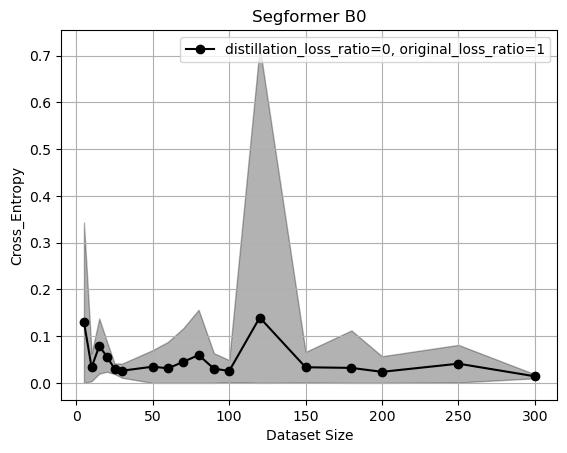

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()